In [36]:
import os
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

In [3]:
def gram_schmidt_process(A):
    n = A.shape[1]
    dim = A.shape[0]
    # Initialize the orthonormal basis matrix
    Q = np.zeros((dim, n)).astype('float')
    
    for i in range(n):
        # Start with the original vector
        q = A[:, i]
        for j in range(i):
            # Subtract the projection of q onto the j-th orthonormal vector
            q -= np.dot(Q[:, j], A[:, i]) * Q[:, j]
        # Normalize the vector
        Q[:, i] = q / np.linalg.norm(q)
    
    return Q #notice that the Q is the eigenvector matrix (column matrix)


def construct_Q(S):
    d = len(S)
    Q = np.zeros(S.shape)
    gamma = np.trace(S)/d
    basis = np.eye(d)
    # basis = orthgroup.rvs(dim=d)

    # construct the i-th column of Q
    for i in range(d-1):
        inner_prod_S = np.array([np.real(np.dot(basis[:,i], np.dot(S, basis[:,i]))) for i in range(basis.shape[1])])
        equal_index = next((index for index, value in enumerate(inner_prod_S) if value == gamma), -1)
        # print(equal_index)
        if equal_index != -1:
            Q[:,i] = basis[:,equal_index]
            basis = np.delete(basis, equal_index, axis=1)
            basis = gram_schmidt_process(basis)
            continue
        # big_index = np.argmax(inner_prod_S)
        # small_index = np.argmin(inner_prod_S)
        big_index = next((index for index, value in enumerate(inner_prod_S) if value > gamma), -1)
        small_index = next((index for index, value in enumerate(inner_prod_S) if value < gamma), -1)
        big_vec = basis[:,big_index]
        small_vec = basis[:,small_index]
        # print('inner_prod_S, big_vec, small_vec', inner_prod_S, big_vec, small_vec)
        a0, a1, b = inner_prod_S[small_index], inner_prod_S[big_index], np.dot(basis[:,big_index], np.dot(S, basis[:,small_index]))
        tan_theta = (-b+np.sqrt(b**2+(a1-gamma)*(gamma-a0)))/(a1-gamma)
        # print('a0, a1, b, tan_theta', a0, a1, b, tan_theta)
        new_vec = (small_vec + tan_theta*big_vec)/np.sqrt(1+tan_theta**2)
        # print('new_vec inner prod:', new_vec, new_vec@S@new_vec)
        Q[:,i] = new_vec
        basis = np.delete(basis, big_index, axis=1)
        new_basis = np.insert(basis, 0, new_vec, axis=1)
        basis = gram_schmidt_process(new_basis)[:,1:]
    Q[:,-1] = basis[:,0]

    return Q

# output is J, not J_tilde!!!
def construct_J(Q, S, Lambda, random_Lambda=False):
    d = len(Q)
    J = np.zeros(Q.shape)
    for i in range(d):
        for j in range(d):
            if i == j:
                continue
            if random_Lambda:
                J[i,j] = (Lambda[i]+Lambda[j])/(Lambda[i]-Lambda[j]) * np.dot(Q[:,i], np.dot(S, Q[:,j]))
            else:
                J[i,j] = np.sign(Lambda[i]-Lambda[j]) * np.dot(Q[:,i], np.dot(S, Q[:,j]))
    J_tilde = Q@J@Q.T
    sqrt_S_inv = np.linalg.inv(scipy.linalg.sqrtm(S))
    J = sqrt_S_inv@J_tilde@sqrt_S_inv
    return J.real



def langevin_dynamics_high_dim(x0, potential_grad, dt, n_steps, S, J = None):
    dim = len(x0)
    if J is None:
        J = np.diag(np.zeros(dim))

    # Initialize position and trajectory
    x = copy.copy(x0)
    trajectory = [x]
    dim = len(x0)
    sqrt_2dt = np.sqrt(2 * dt)
    
    # Langevin dynamics loop
    for _ in range(n_steps):
        # Compute deterministic force
        force = -potential_grad(x, J, S)
        # print(force)
        
        # Generate random noise
        noise = np.random.normal(size=dim)
        
        # Langevin equationiven
        x = x + dt * force + sqrt_2dt * noise
        trajectory.append(x)
    
    return np.array(trajectory)

# S = ...
def scaled_gaussian(x, J, S):
    dim = len(x)
    sigma = (np.eye(dim)+J)@S
    return sigma@x



def getoptJ(S):
    d = S.shape[0]
    J = None
    value = np.inf
    for _ in range(10):
        Q = construct_Q(S)
        Lambda = np.random.rand(d)
        J_current = construct_J(Q, S, Lambda, random_Lambda=False)
        if np.trace(-J_current@S@J_current) < value:
            J = J_current
            value = np.trace(-J_current@S@J_current)
    Q = construct_Q(S)
    Lambda = np.arange(d)
    J = construct_J(Q, S, Lambda, random_Lambda=False)
    return J

def getnoptJ(S):
    d = S.shape[0]
    Q = construct_Q(S)
    Lambda = np.random.rand(d)
    J_opt = construct_J(Q, S, Lambda, random_Lambda=False)
    value = np.trace(-J_opt@S@J_opt)
    for _ in range(100):
        Lambda = np.random.rand(d)
        J = construct_J(Q, S, Lambda, random_Lambda=True)
        if np.trace(-J@S@J) < 5*value:
            return J
    Lambda = np.arange(d)
    J = construct_J(Q, S, Lambda, random_Lambda=True)
    return J

def getJ(S):
    d = S.shape[0]
    J = np.random.rand(d,d)
    J = (J - J.T)/2
    return J/np.linalg.norm(J, ord='fro') # normalize the Frobenius norm of J to 1

In [6]:
sigma_true = [2**i for i in range(4)]
cov_true = np.diag(sigma_true)**2
S = np.linalg.inv(cov_true)
opt_norm_ave = 9.13

In [11]:
ESJD_S = []
Frob_S = []
N = 100
for i in range(N):
    J = getJ(np.diag(sigma_true)) * opt_norm_ave / 2
    ESJD_S.append(-np.trace(J@S@J))
    Frob_S.append(np.linalg.norm(J, ord='fro'))

In [12]:
ESJD_M = []
Frob_M = []
N = 100
for i in range(N):
    J = getJ(np.diag(sigma_true)) * opt_norm_ave
    ESJD_M.append(-np.trace(J@S@J))
    Frob_M.append(np.linalg.norm(J, ord='fro'))

In [13]:
ESJD_L = []
Frob_L = []
N = 100
for i in range(N):
    J = getJ(np.diag(sigma_true)) * opt_norm_ave * 2
    ESJD_L.append(-np.trace(J@S@J))
    Frob_L.append(np.linalg.norm(J, ord='fro'))

In [16]:
ESJD_SO = []
Frob_SO = []
N = 100
for i in range(N):
    J = getnoptJ(np.diag(sigma_true))
    ESJD_SO.append(-np.trace(J@S@J))
    Frob_SO.append(np.linalg.norm(J, ord='fro'))

In [17]:
ESJD_O = []
Frob_O = []
N = 100
for i in range(N):
    J = getoptJ(np.diag(sigma_true))
    ESJD_O.append(-np.trace(J@S@J))
    Frob_O.append(np.linalg.norm(J, ord='fro'))

In [32]:
def plot_esjd_frob_histograms(methods, ESJD_list, Frob_list, tolerance=1e-1):
    """
    Creates two subplots:
    - One for the histogram of ESJD values across different methods.
    - One for the histogram of Frobenius norm values across different methods.

    If data values are all very close (within `tolerance`), draw a vertical line instead of a histogram.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot ESJD histograms
    for method, esjd in zip(methods, ESJD_list):
        esjd = np.asarray(esjd)
        if len(esjd) == 0 or not np.isfinite(esjd).any():
            continue
        if np.max(esjd) - np.min(esjd) < tolerance:
            avg_val = np.mean(esjd)
            axes[0].axvline(avg_val, linestyle='--', label=f'{method} ({avg_val:.2f})')
        else:
            axes[0].hist(esjd, bins=30, alpha=0.5, label=method, density=True)
    axes[0].set_title("Histogram of ESJD by Method")
    axes[0].set_xlabel("ESJD")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True)

    # Plot Frobenius norm histograms
    for method, frob in zip(methods, Frob_list):
        frob = np.asarray(frob)
        if len(frob) == 0 or not np.isfinite(frob).any():
            continue
        if np.max(frob) - np.min(frob) < tolerance:
            avg_val = np.mean(frob)
            axes[1].axvline(avg_val, linestyle='--', label=f'{method} ({avg_val:.2f})')
        else:
            axes[1].hist(frob, bins=30, alpha=0.5, label=method, density=True)
    axes[1].set_title("Histogram of Frobenius Norm by Method")
    axes[1].set_xlabel("Frobenius Norm")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

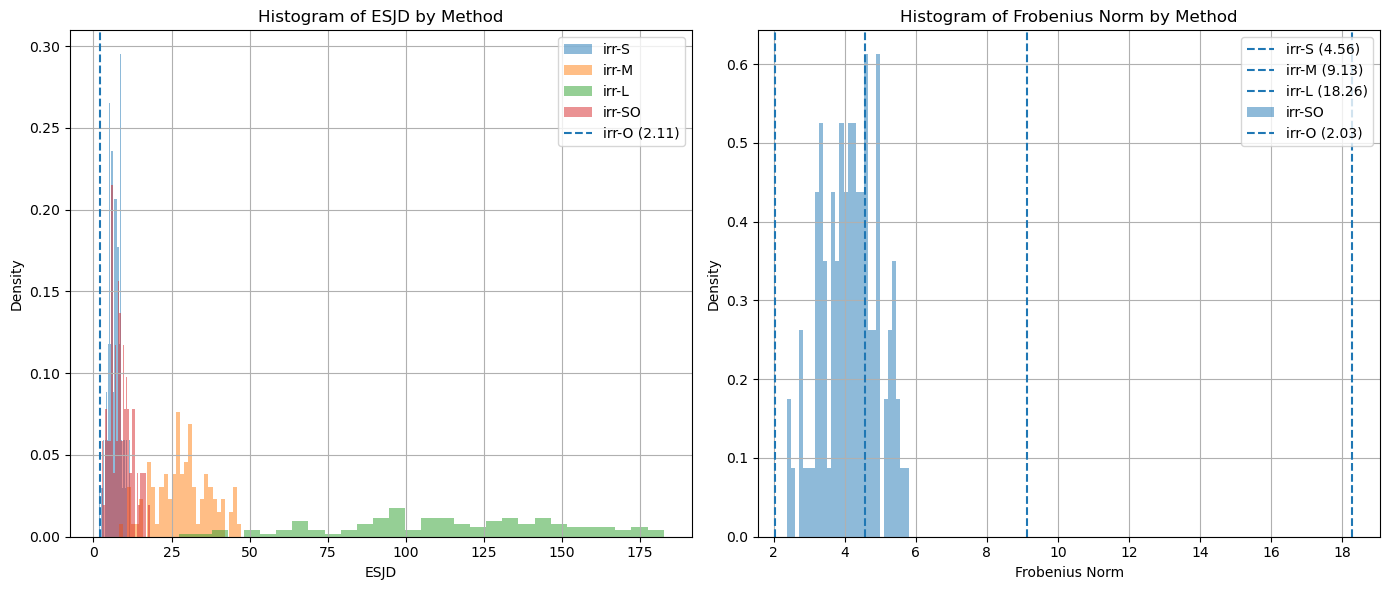

In [33]:
methods = ['irr-S', 'irr-M', 'irr-L', 'irr-SO', 'irr-O']
ESJD_list = [ESJD_S, ESJD_M, ESJD_L, ESJD_SO, ESJD_O]
Frob_list = [Frob_S, Frob_M, Frob_L, Frob_SO, Frob_O]
plot_esjd_frob_histograms(methods, ESJD_list, Frob_list)

In [41]:
def plot_esjd_frob_histograms(methods, ESJD_list, Frob_list, tolerance=1e-5):
    """
    Creates two subplots:
    - One for the KDE plot of ESJD values across different methods.
    - One for the KDE plot of Frobenius norm values across different methods.

    KDE is restricted to the support of the original data to avoid misleading tails.
    If data values are all very close (within `tolerance`), draw a vertical line.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot ESJD KDEs
    for method, esjd in zip(methods, ESJD_list):
        esjd = np.asarray(esjd)
        if len(esjd) == 0 or not np.isfinite(esjd).any():
            continue
        min_val, max_val = np.min(esjd), np.max(esjd)
        if max_val - min_val < tolerance:
            avg_val = np.mean(esjd)
            axes[0].axvline(avg_val, linestyle='--', label=f'{method} ({avg_val:.2f})')
        else:
            sns.kdeplot(esjd, ax=axes[0], label=method, linewidth=2, clip=(min_val, max_val))
    axes[0].set_title("KDE of ESJD by Method")
    axes[0].set_xlabel("ESJD")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True)

    # Plot Frobenius norm KDEs
    for method, frob in zip(methods, Frob_list):
        frob = np.asarray(frob)
        if len(frob) == 0 or not np.isfinite(frob).any():
            continue
        min_val, max_val = np.min(frob), np.max(frob)
        if max_val - min_val < tolerance:
            avg_val = np.mean(frob)
            axes[1].axvline(avg_val, linestyle='--', label=f'{method} ({avg_val:.2f})')
        else:
            sns.kdeplot(frob, ax=axes[1], label=method, linewidth=2, clip=(min_val, max_val))
    axes[1].set_title("KDE of Frobenius Norm by Method")
    axes[1].set_xlabel("Frobenius Norm")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


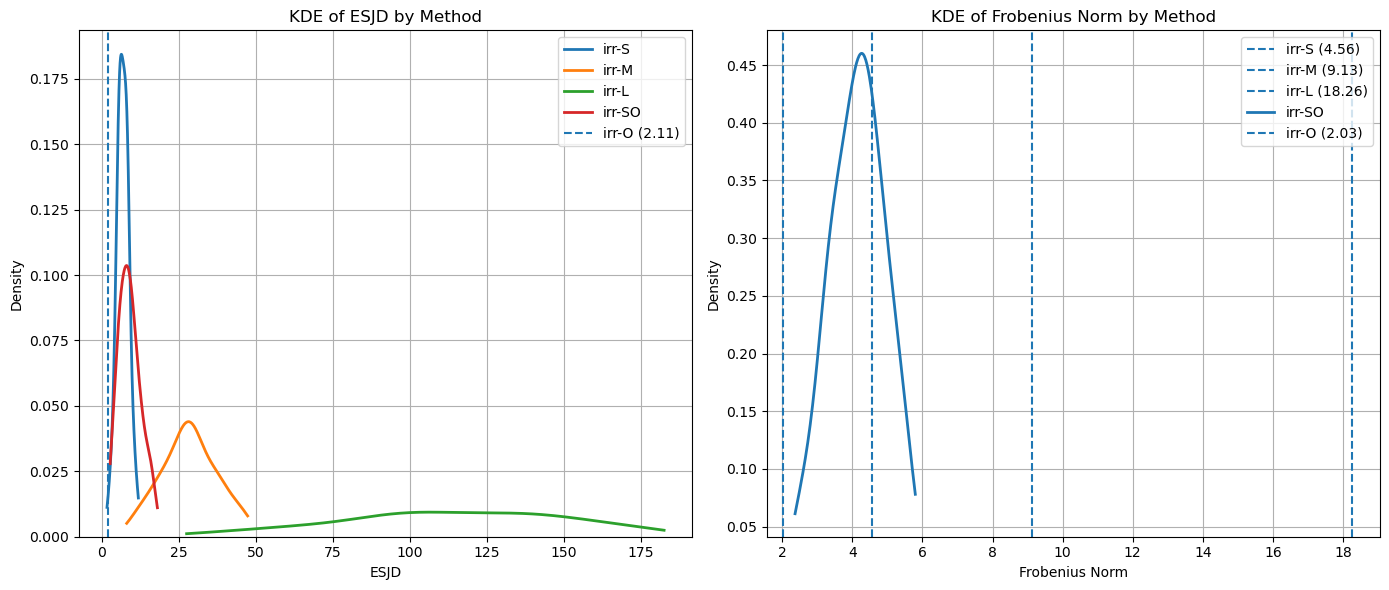

In [43]:
plot_esjd_frob_histograms(methods, ESJD_list, Frob_list)